In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Commodities', min_assets=.2), 60, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-05-13 to 2019-07-12 - 21


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

12


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
PALL,38,2.177991,2.678253,0.798397,17.034726,2.616506
SGOL,38,1.139213,2.060732,0.533563,8.894211,2.692057
IAU,38,1.138925,2.084088,0.527445,8.842447,2.716592
BAR,38,1.138480,2.056328,0.534349,8.957528,2.700990
GLD,38,1.131130,2.042869,0.534272,8.853021,2.667662
GLTR,38,1.013215,1.753722,0.555124,7.715411,2.274879
PSLV,38,0.931161,1.975512,0.451265,6.805296,3.013180
DBA,38,0.717971,1.425401,0.475858,8.617358,2.544381
SIVR,38,0.432797,1.776949,0.221230,3.066199,2.866669


evicted DJP 0.849 0.059
evicted COMT 0.391 -0.255
evicted PSLV 0.890 -0.485
retry backlogs ['SLV', 'IAU', 'GLD', 'GLTR', 'SIVR', 'SGOL'] at 0.905/-0.51 - 1.208
evicted SIVR 0.890 -0.399
retry backlogs ['GLTR', 'IAU', 'SLV', 'GLD', 'SGOL'] at 0.910/-0.52 - 1.208
evicted SLV 0.895 -0.405
retry backlogs ['GLTR', 'IAU', 'GLD', 'SGOL'] at 0.915/-0.53 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.920/-0.54 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.925/-0.55 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.930/-0.56 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.935/-0.57 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.940/-0.58 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.945/-0.59 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.950/-0.60 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.955/-0.61 - 1.208
retry backlogs ['GLTR', 'GLD', 'IAU', 'SGOL'] at 0.960/-0.62 - 1.208
retry backlogs ['GLTR',

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,38.0,1.194331,0.956295,-0.712919,0.444517,1.308269,2.002635,2.971756,1.207419,10.795097,1.043974
PALL,38.0,2.177991,2.678253,-2.054957,0.096636,1.822596,3.774399,7.906003,0.798397,17.034726,2.616506
BAR,38.0,1.138480,2.056328,-2.494698,0.000000,0.750392,2.372678,5.833955,0.534349,8.957528,2.700990
DBA,38.0,0.717971,1.425401,-1.775143,-0.238937,0.364123,1.961135,3.729897,0.475858,8.617358,2.544381


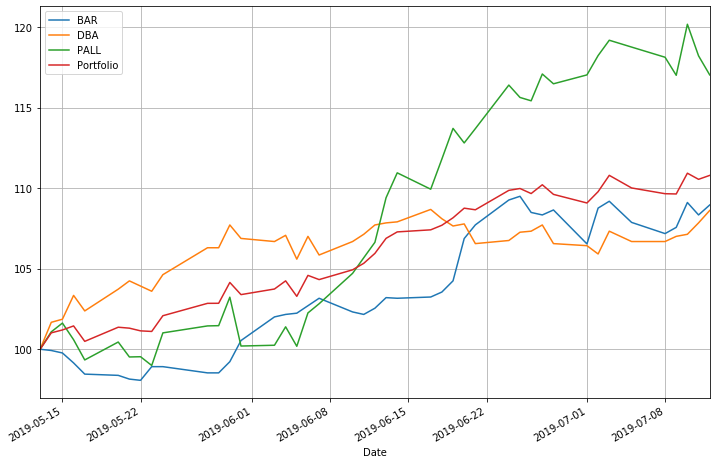

In [4]:
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=2)
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=2))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)